In [3]:
!pip install pandas
!pip install openpyxl


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [5]:
df = pd.read_excel("CRNA Demand Data Anonymized.xlsx")
df.head()

Date   In Room  Out Room  Count
0 2025-01-01  13:50:00  15:07:00      2
1 2025-01-01  08:27:00  09:18:00      1
2 2025-01-01  12:13:00  14:31:00      1
3 2025-01-01  14:57:00  15:15:00      1
4 2025-01-01  16:51:00  17:40:00      1

In [ ]:
def assign_month_week(df):
    df['Date'] = pd.to_datetime(df['Date'])  # ensure Date column is datetime

    # Extract day of month
    df['day'] = df['Date'].dt.day

    # Assign week number based on day ranges
    df['week_of_month'] = pd.cut(df['day'],
        bins=[0, 7, 14, 21, 28, 31],  # cutoffs
        labels=['Week1', 'Week2', 'Week3', 'Week4', 'Week5'],
        right=True)
    return df
weekfile=assign_month_week(df)
weekfile
#code for dividing data into week form

Date   In Room  Out Room  Count  day week_of_month
0    2025-01-01  13:50:00  15:07:00      2    1         Week1
1    2025-01-01  08:27:00  09:18:00      1    1         Week1
2    2025-01-01  12:13:00  14:31:00      1    1         Week1
3    2025-01-01  14:57:00  15:15:00      1    1         Week1
4    2025-01-01  16:51:00  17:40:00      1    1         Week1
...         ...       ...       ...    ...  ...           ...
3349 2025-03-31  15:32:00  17:31:00      1   31         Week5
3350 2025-03-31  13:36:00  15:41:00      1   31         Week5
3351 2025-03-31  10:41:00  13:11:00      1   31         Week5
3352 2025-03-31  19:42:00  20:57:00      1   31         Week5
3353 2025-03-31  07:42:00  10:28:00      1   31         Week5

[3354 rows x 6 columns]

In [ ]:
w1_df = weekfile[weekfile['week_of_month'] == 'Week1']
w2_df=  weekfile[weekfile['week_of_month'] == 'Week2']
w3_df=  weekfile[weekfile['week_of_month'] == 'Week3']
w4_df=  weekfile[weekfile['week_of_month'] == 'Week4']
w5_df=  weekfile[weekfile['week_of_month'] == 'Week5']
w1_df=w1_df[['Date','In Room','Out Room','Count']]
w2_df=w2_df[['Date','In Room','Out Room','Count']]
w3_df=w3_df[['Date','In Room','Out Room','Count']]
w4_df=w4_df[['Date','In Room','Out Room','Count']]
w5_df=w5_df[['Date','In Room','Out Room','Count']]
#code for selecting required data


In [22]:
w1_df.to_csv("week1 for three months.csv", index= True)

In [10]:
weekfile.groupby('week_of_month')['Count'].sum()

/tmp/ipykernel_2246/2323968566.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weekfile.groupby('week_of_month')['Count'].sum()


week_of_month
Week1    713
Week2    795
Week3    931
Week4    923
Week5    240
Name: Count, dtype: int64

In [11]:
def get_bins():
    return [f"{datetime(2023, 1, 1, h).strftime('%H:%M')} - {(datetime(2023, 1, 1, h) + timedelta(hours=1)).strftime('%H:%M')}" for h in range(24)]

def presence_slots(t_in, t_out, mult=1):
    bins = get_bins()
    pres = [0] * 24

    if not isinstance(t_in, datetime):
        t_in = datetime.strptime(str(t_in), '%H:%M')
    if not isinstance(t_out, datetime):
        t_out = datetime.strptime(str(t_out), '%H:%M')
    if t_out < t_in:
        t_out += timedelta(days=1)

    for i, rng in enumerate(bins):
        s, e = rng.split(' - ')
        s = datetime(1900, 1, 1, int(s[:2]), 0)
        e = datetime(1900, 1, 1, int(e[:2]), 0)
        if e <= s:
            e += timedelta(days=1)

        t1 = datetime(1900, 1, 1, t_in.hour, t_in.minute)
        t2 = datetime(1900, 1, 1, t_out.hour, t_out.minute)
        if t2 <= t1:
            t2 += timedelta(days=1)

        if max(t1, s) < min(t2, e):
            pres[i] = mult
    return pres

def make_df(t_in, t_out, c=1):
    bins = get_bins()
    pres = presence_slots(t_in, t_out, mult=c)
    return pd.DataFrame({'Time Range': bins, 'Presence': pres})

In [12]:
path = "CRNA Demand Data Anonymized.xlsx"
df = pd.read_excel(path, dtype={'In Room': str, 'Out Room': str}, sheet_name='in')
df = df.dropna(ignore_index=True)

has_cnt = 'Count' in df.columns
frames = []

for _, row in df.iterrows():
    t1 = row['In Room'][:-3]
    t2 = row['Out Room'][:-3]
    cnt = int(row['Count']) if has_cnt else 1
    temp = make_df(t1, t2, c=cnt).set_index('Time Range').T
    frames.append(temp)

agg = pd.concat(frames, ignore_index=True)
out = pd.concat([df.reset_index(drop=True), agg], axis=1)
out = out.rename(columns={'00:00 - 01:00': 0, '01:00 - 02:00' : 1, '02:00 - 03:00' : 2, '03:00 - 04:00' : 3, '04:00 - 05:00' : 4, '05:00 - 06:00' : 5,
                          '06:00 - 07:00' : 6, '07:00 - 08:00' : 7, '08:00 - 09:00' : 8, '09:00 - 10:00' : 9, '10:00 - 11:00' : 10, '11:00 - 12:00' : 11,
                          '12:00 - 13:00' : 12, '13:00 - 14:00' : 13, '14:00 - 15:00' : 14, '15:00 - 16:00' : 15, '16:00 - 17:00' : 16, '17:00 - 18:00' : 17,
                          '18:00 - 19:00' : 18, '19:00 - 20:00' : 19, '20:00 - 21:00' : 20, '21:00 - 22:00' : 21, '22:00 - 23:00' : 22, '23:00 - 00:00' : 23,})
out

Date   In Room  Out Room  Count  0  1  2  3  4  5  ...  14  15  16  \
0    2025-01-01  13:50:00  15:07:00      2  0  0  0  0  0  0  ...   2   2   0   
1    2025-01-01  08:27:00  09:18:00      1  0  0  0  0  0  0  ...   0   0   0   
2    2025-01-01  12:13:00  14:31:00      1  0  0  0  0  0  0  ...   1   0   0   
3    2025-01-01  14:57:00  15:15:00      1  0  0  0  0  0  0  ...   1   1   0   
4    2025-01-01  16:51:00  17:40:00      1  0  0  0  0  0  0  ...   0   0   1   
...         ...       ...       ...    ... .. .. .. .. .. ..  ...  ..  ..  ..   
3349 2025-03-31  15:32:00  17:31:00      1  0  0  0  0  0  0  ...   0   1   1   
3350 2025-03-31  13:36:00  15:41:00      1  0  0  0  0  0  0  ...   1   1   0   
3351 2025-03-31  10:41:00  13:11:00      1  0  0  0  0  0  0  ...   0   0   0   
3352 2025-03-31  19:42:00  20:57:00      1  0  0  0  0  0  0  ...   0   0   0   
3353 2025-03-31  07:42:00  10:28:00      1  0  0  0  0  0  0  ...   0   0   0   

      17  18  19  20  21  22  23  
0      0   0   0   0   0   0   0  
1      0   0   0   0   0   0   0  
2      0   0   0   0   0   0   0  
3      0   0   0   0   0   0   0  
4      1   0   0   0   0   0   0  
...   ..  ..  ..  ..  ..  ..  ..  
3349   1   0   0   0   0   0   0  
3350   0   0   0   0   0   0   0  
3351   0   0   0   0   0   0   0  
3352   0   0   1   1   0   0   0  
3353   0   0   0   0   0   0   0  

[3354 rows x 28 columns]

In [ ]:
def assign_month_week(df):
    df['Date'] = pd.to_datetime(df['Date'])  # ensure Date column is datetime

    # Extract day of month
    df['day'] = df['Date'].dt.day

    # Assign week number based on day ranges
    df['week_of_month'] = pd.cut(df['day'],
        bins=[0, 7, 14, 21, 28, 31],  # cutoffs
        labels=['Week1', 'Week2', 'Week3', 'Week4', 'Week5'],
        right=True)
    return df
weekfile_detail=assign_month_week(out)
#code for dividing data to weeks

In [14]:
w1d_df=  weekfile_detail[weekfile_detail['week_of_month'] == 'Week1']
w1d_df

Date   In Room  Out Room  Count  0  1  2  3  4  5  ...  16  17  18  \
0    2025-01-01  13:50:00  15:07:00      2  0  0  0  0  0  0  ...   0   0   0   
1    2025-01-01  08:27:00  09:18:00      1  0  0  0  0  0  0  ...   0   0   0   
2    2025-01-01  12:13:00  14:31:00      1  0  0  0  0  0  0  ...   0   0   0   
3    2025-01-01  14:57:00  15:15:00      1  0  0  0  0  0  0  ...   0   0   0   
4    2025-01-01  16:51:00  17:40:00      1  0  0  0  0  0  0  ...   1   1   0   
...         ...       ...       ...    ... .. .. .. .. .. ..  ...  ..  ..  ..   
2501 2025-03-07  07:36:00  08:32:00      1  0  0  0  0  0  0  ...   0   0   0   
2502 2025-03-07  09:24:00  10:22:00      1  0  0  0  0  0  0  ...   0   0   0   
2503 2025-03-07  13:23:00  14:58:00      1  0  0  0  0  0  0  ...   0   0   0   
2504 2025-03-07  11:40:00  12:56:00      1  0  0  0  0  0  0  ...   0   0   0   
2505 2025-03-07  10:38:00  10:57:00      1  0  0  0  0  0  0  ...   0   0   0   

      19  20  21  22  23  day  week_of_month  
0      0   0   0   0   0    1          Week1  
1      0   0   0   0   0    1          Week1  
2      0   0   0   0   0    1          Week1  
3      0   0   0   0   0    1          Week1  
4      0   0   0   0   0    1          Week1  
...   ..  ..  ..  ..  ..  ...            ...  
2501   0   0   0   0   0    7          Week1  
2502   0   0   0   0   0    7          Week1  
2503   0   0   0   0   0    7          Week1  
2504   0   0   0   0   0    7          Week1  
2505   0   0   0   0   0    7          Week1  

[666 rows x 30 columns]

In [ ]:

w1d_df=  weekfile_detail[weekfile_detail['week_of_month'] == 'Week1']
w2d_df=  weekfile_detail[weekfile_detail['week_of_month'] == 'Week2']
w3d_df=  weekfile_detail[weekfile_detail['week_of_month'] == 'Week3']
w4d_df=  weekfile_detail[weekfile_detail['week_of_month'] == 'Week4']
w5d_df=  weekfile_detail[weekfile_detail['week_of_month'] == 'Week5']
df1=weekday_hour_summary(w5d_df)
df1=(df1/3).round().fillna(0).astype(int)
df1
#code for creating month-friday dateframe for each week


/tmp/ipykernel_2246/457193701.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])
/tmp/ipykernel_2246/457193701.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = df['Date'].dt.day_name()


0   1   2   3   4   5   6   7   8   9   ...  14  15  16  17  18  \
weekday                                            ...                       
Monday      0   0   0   0   0   0   0   2   3   4  ...   5   4   3   2   1   
Tuesday     0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   
Wednesday   0   0   0   0   0   0   0   3   5   5  ...   4   3   2   2   1   
Thursday    0   0   0   0   0   0   0   3   5   5  ...   5   4   3   2   1   
Friday      0   0   0   0   0   0   1   3   4   5  ...   3   5   3   3   2   
Saturday    0   0   0   0   0   0   0   0   0   1  ...   0   0   1   1   0   
Sunday      0   0   0   0   0   0   0   0   0   0  ...   0   0   0   1   1   

           19  20  21  22  23  
weekday                        
Monday      0   0   0   0   0  
Tuesday     0   0   0   0   0  
Wednesday   0   0   0   0   0  
Thursday    0   0   0   0   0  
Friday      1   1   0   0   0  
Saturday    0   0   0   0   0  
Sunday      1   0   0   0   0  

[7 rows x 24 columns]

In [39]:
df1.to_csv("week5 aggregation.csv", index= True)

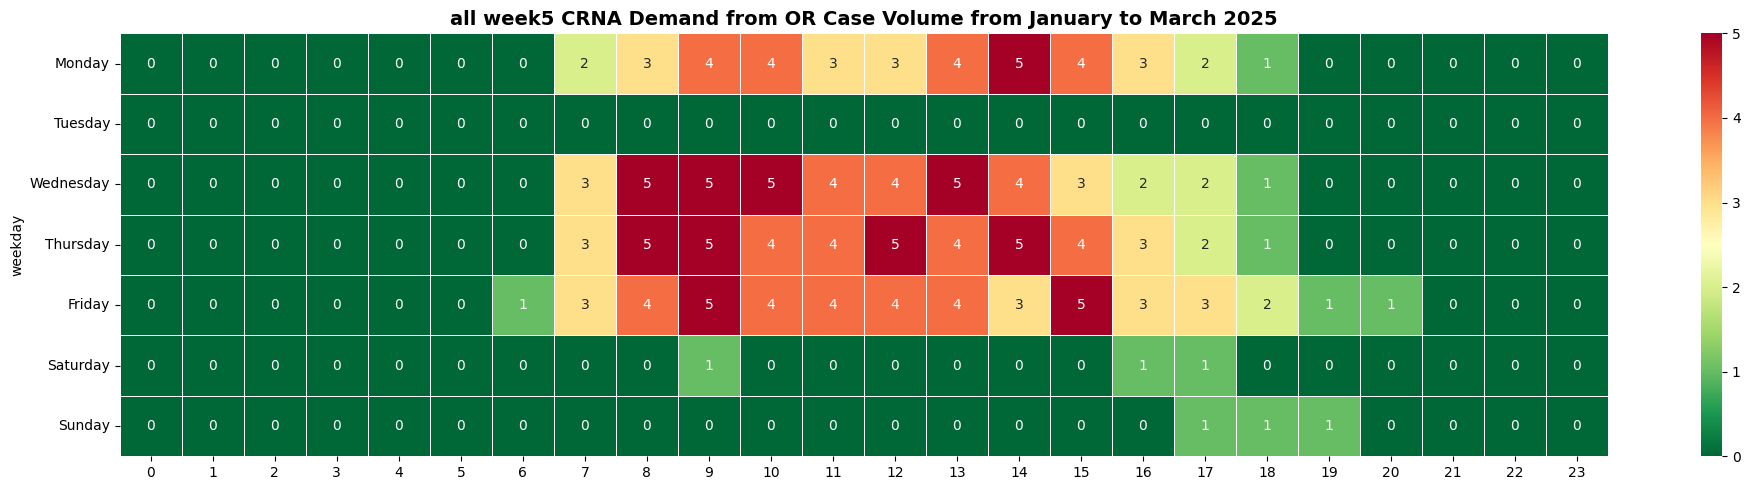

In [ ]:
title = 'all week5 CRNA Demand from OR Case Volume from January to March 2025'
font = {'fontsize': 14, 'fontweight': 'bold'}
plt.figure(figsize=(20, 5)) 
heatmap = sns.heatmap(df1, annot = True, 
                      linewidths=0.5, cmap='RdYlGn_r')
plt.title(title, fontdict=font)
plt.tight_layout()
#code for creating heatmap

## Work form here

In [ ]:
"""
Create an aggregated dataframe by following the instructions below:

1) Write a function that sums the values of columns "0" to "23" and group them by day of week (use date column)
2) Write another function that inputs start date and end date and outputs no of days of Sundays, Mondays, .........,  Saturdays (this is your denominator)
3) Create agg_df by dividing the day of week sums by the denominators

"""

'\nCreate an aggregated dataframe by following the instructions below:\n\n1) Write a function that sums the values of columns "0" to "23" and group them by day of week (use date column)\n2) Write another function that inputs start date and end date and outputs no of days of Sundays, Mondays, .........,  Saturdays (this is your denominator)\n3) Create agg_df by dividing the day of week sums by the denominators\n\n'

In [ ]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
def weekday_hour_summary(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['weekday'] = df['Date'].dt.day_name()

    hour_columns = list(range(24))  
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    result = df.groupby('weekday')[hour_columns].sum()
    result = result.reindex(weekday_order)

    return result 
weekday_hour_summary(out)
#code for assigning weekday for data and group by day_name

0   1   2   3   4   5   6    7    8    9   ...   14   15   16  17  \
weekday                                               ...                      
Monday      3   3   1   1   3   5   3   94  140  158  ...  152  143  117  73   
Tuesday     1   1   1   1   1   2   1  104  159  177  ...  150  127   95  73   
Wednesday   0   2   2   1   1   1   1  101  166  175  ...  154  129  107  80   
Thursday    2   4   3   0   2   1   0    8  147  210  ...  185  165  129  95   
Friday      4   6   4   4   4   3   4  104  150  169  ...  164  146  114  86   
Saturday    4   4   2   2   2   1   1    6   15   25  ...   19   16   19  15   
Sunday      0   1   2   3   2   4   4    7   20   27  ...   13   12   14  12   

           18  19  20  21  22  23  
weekday                            
Monday     44  20  15  16  12  10  
Tuesday    47  41  31  19  12   6  
Wednesday  55  29  18   8   4   6  
Thursday   49  32  24  19  11   3  
Friday     50  30  22  21  11   7  
Saturday    9   4   5   3   3   5  
Sunday     10  11   3   0   1   1  

[7 rows x 24 columns]

In [ ]:
ordered_days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
def count_of_weekday(start_date, end_date):
    daterange=pd.date_range(start=start_date,end=end_date)
    weekday=daterange.day_name()
    daycount=weekday.value_counts()
    
    result = daycount.reindex(ordered_days, fill_value=0)
    return result
print(count_of_weekday('2025-01-01','2025-03-31'))
#code for counting the number of day_name

Sunday       13
Monday       13
Tuesday      12
Wednesday    13
Thursday     13
Friday       13
Saturday     13
Name: count, dtype: int64


In [ ]:
agg_df=(weekday_hour_summary(out).div(count_of_weekday('2025-01-01','2025-03-31'), axis=0))
agg_df=agg_df.reindex(weekday_order)
agg_df
#code for averaging the result

0         1         2         3         4         5   \
Monday     0.230769  0.230769  0.076923  0.076923  0.230769  0.384615   
Tuesday    0.083333  0.083333  0.083333  0.083333  0.083333  0.166667   
Wednesday  0.000000  0.153846  0.153846  0.076923  0.076923  0.076923   
Thursday   0.153846  0.307692  0.230769  0.000000  0.153846  0.076923   
Friday     0.307692  0.461538  0.307692  0.307692  0.307692  0.230769   
Saturday   0.307692  0.307692  0.153846  0.153846  0.153846  0.076923   
Sunday     0.000000  0.076923  0.153846  0.230769  0.153846  0.307692   

                 6         7          8          9   ...         14  \
Monday     0.230769  7.230769  10.769231  12.153846  ...  11.692308   
Tuesday    0.083333  8.666667  13.250000  14.750000  ...  12.500000   
Wednesday  0.076923  7.769231  12.769231  13.461538  ...  11.846154   
Thursday   0.000000  0.615385  11.307692  16.153846  ...  14.230769   
Friday     0.307692  8.000000  11.538462  13.000000  ...  12.615385   
Saturday   0.076923  0.461538   1.153846   1.923077  ...   1.461538   
Sunday     0.307692  0.538462   1.538462   2.076923  ...   1.000000   

                  15        16        17        18        19        20  \
Monday     11.000000  9.000000  5.615385  3.384615  1.538462  1.153846   
Tuesday    10.583333  7.916667  6.083333  3.916667  3.416667  2.583333   
Wednesday   9.923077  8.230769  6.153846  4.230769  2.230769  1.384615   
Thursday   12.692308  9.923077  7.307692  3.769231  2.461538  1.846154   
Friday     11.230769  8.769231  6.615385  3.846154  2.307692  1.692308   
Saturday    1.230769  1.461538  1.153846  0.692308  0.307692  0.384615   
Sunday      0.923077  1.076923  0.923077  0.769231  0.846154  0.230769   

                 21        22        23  
Monday     1.230769  0.923077  0.769231  
Tuesday    1.583333  1.000000  0.500000  
Wednesday  0.615385  0.307692  0.461538  
Thursday   1.461538  0.846154  0.230769  
Friday     1.615385  0.846154  0.538462  
Saturday   0.230769  0.230769  0.384615  
Sunday     0.000000  0.076923  0.076923  

[7 rows x 24 columns]

In [28]:
agg_df.to_csv("demand for three months.csv", index= True)

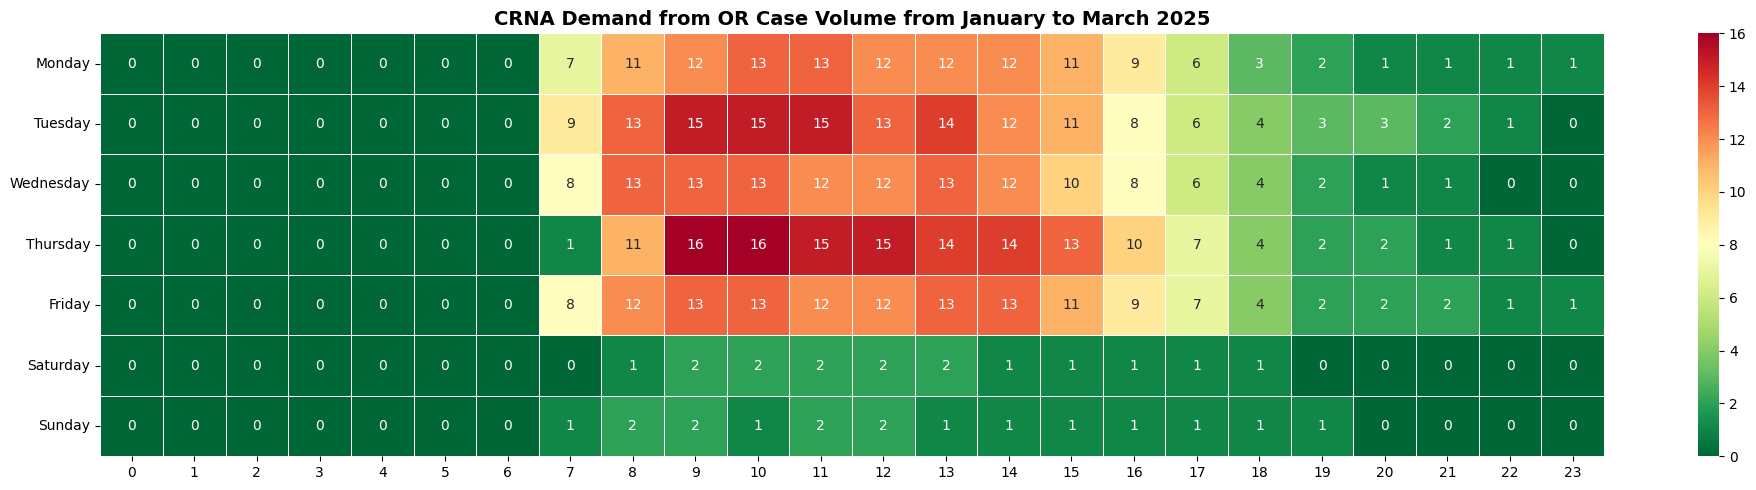

In [ ]:
title = 'CRNA Demand from OR Case Volume from January to March 2025'
font = {'fontsize': 14, 'fontweight': 'bold'}
plt.figure(figsize=(20, 5)) 
heatmap = sns.heatmap(agg_df, annot = True, 
                      linewidths=0.5, cmap='RdYlGn_r')
plt.title(title, fontdict=font)
plt.tight_layout()
#plt.savefig('demand_heatmap.png', dpi = 400)